# **Sentiment Analysis using LSTM**
In this week's graded assignment, you will implement a neural network that will perform senyiment analysis on movie reviews and classify them as positive or negative.

You are to only write/modify the code in between consecutive `# <START>` and `# <END>` comments. DO NOT modify other parts of the notebook, your assignments will not be graded otherwise.

```python
"Don't modify any code here"

# <START>
"YOUR CODE GOES HERE!"
# <END>

"Don't modify any code here"
```
## **Before you begin**
Before you start with the assignment, you will have to upload the CSV file containing the movie reviews you will classify to your Google Drive. Here's a link to the dataset: [Dataset Link](https://drive.google.com/file/d/1nqmfdx7dj5qgynVwzD1CMjFFZoBeKrmD/view?usp=sharing)  
Download **reviews.csv** and upload it to your Drive.

### **Make sure to upload to the same account that you are using on Colab, otherwise you won't be able to access the files**


## **Mounting Google Drive**
First, we need to import the dataset from your Google Drive. To do so, **run the below cell**. This will mount your Drive to the running Colab instance. Then, you will be able to access all your Google Drive data in this notebook.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import the Libraries**

Run the cell below to import all the necessary libraries for building the sentiment analysis model.

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

!pip install tqdm
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Loading the Dataset**

The below cell contains a function `getdata`, which takes as argument the path to `reviews.csv` in your Google Drive, loads the CSV file into a Pandas DataFrame and finally returns the DataFrame.

Complete the function and then add the path to `IMDB Dataset.csv` in the space indicated. Run the cell to load the dataset.

In [25]:
def getdata(path):

  # <START>
  df = pd.read_csv(path)
  return df
  # <END>

# Insert the path to the file in the space below
# <START>
path = '/content/drive/MyDrive/reviews.csv'
# <END>

df = getdata(path)
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## **Splitting the Dataset into Training and Testing Data**
Complete the below cell that splits the loaded data into training and testing sets. The recommended train:test ratio is 80:20, but feel free to change this later and see how it affects the accuracy of the model. Note that the cell should store the training and testing reviews in `x_train` and `x_test` respectively, and their corresponding sentiments in `y_train` and `y_test` respectively.

<details>
  <summary>Hint</summary>
  Check out the train_test_split function from sklearn.
  Do not forget to shuffle the dataset!
</details>

In [26]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# <START>
x_train = train_df['review']
x_test = test_df['review']
y_train = train_df['sentiment']
y_test = test_df['sentiment']
# <END>

print(x_train.shape)
print(x_test.shape)

(40000,)
(10000,)


Before we proceed, let's make sure we have a well distributed training dataset by checking the number of positive and negative reviews it contains.

If your values deviate too much from the optimal 50-50 ratio, it is recommended that you modify the above cell to shuffle the dataset differently.

In [27]:
count_positive = 0
count_negative = 0

for i in y_train:
  if i == "positive":
    count_positive += 1
  elif i =="negative":
    count_negative += 1

print("Positive reviews:", count_positive/(count_positive + count_negative)*100, "%")
print("Negative reviews:", count_negative/(count_positive + count_negative)*100, "%")

Positive reviews: 49.902499999999996 %
Negative reviews: 50.0975 %


## **Preprocessing**
As you saw in last week's assignment, preprocessing a very important step in NLP. Complete the below function to perform the following tasks. The function should take as input a set of reviews `x_train` or `x_test`, and return a list of preprocessed reviews.


1.   Case the corpus to lower case
2.   Remove punctuation
3.   Lemmatize
4.   Remove stop words

Feel free to refer to last week's assignment for guidance.

*Note that as the dataset is much larger this time, the cell may take a while to run.*

In [28]:
#The list of stopwords has been coverted into a set, making it faster to check if a given word is in it
stop_words = set(stopwords.words('english'))

# Using the below tokenizer helps us get rid of punctuation,
tokenizer = RegexpTokenizer(r'\w+')
# And the lemmatizer to convert words to simpler forms
lemmatizer = WordNetLemmatizer()

def preprocess(x_set):
    result = []
    for i in x_set:
      # <START>

      i=i.lower()                # Convert to lowercase
      tokens=tokenizer.tokenize(i)    # Tokenize the sentence and remove punctuation

      out = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
      # <END>
      result.append(out)
    return result

#Testing the function
test_preprocess = preprocess(["This is an assignment.",'The notebook runs on the cloud.','The cloud, however, is very much on the ground,'])
print(test_preprocess)
assert test_preprocess == [['assignment'], ['notebook', 'run', 'cloud'], ['cloud', 'however', 'much', 'ground']]

x_train_preprocessed = preprocess(x_train)
x_test_preprocessed = preprocess(x_test)

[['assignment'], ['notebook', 'run', 'cloud'], ['cloud', 'however', 'much', 'ground']]


## **Building the Vocabulary**
Complete the below function which takes as argument the preprocessed **training set** and returns a dictionary mapping each unique word to a unique ID. However this time, we shall begin with giving the first word an ID of `1`. The reason for this will become clear soon.

Again, feel free to refer to last week's assignment.

In [29]:
def create_vocabulary(x_train_preprocessed):
  '''Creates a dictionary with all unique words in corpus with id'''
  vocabulary = {}
  id = 1
  # <START>
  for s in x_train_preprocessed:
    for token in s:
      if token not in vocabulary:
        vocabulary[token] = id
        id += 1
  # <END>
  return vocabulary

vocabulary = create_vocabulary(x_train_preprocessed)
print(len(vocabulary))

83978


## **Converting to Numerical Form**
Since we need to convert our words into numerical input for the neural network to be able to process it, let's replace the words in our reviews with their corresponding IDs from the vocabulary (not their one-hot embeddings, just their IDs).

Complete the below function that takes as input the set of reviews (`x_train_preprocessed` and `x_test_preprocessed`) and converts them to their numerical form.


In [30]:
def convert_to_numerical(x_set):
  converted = []
    # <START>
  for x in x_set:
    converted.append([vocabulary[token] for token in x if token in vocabulary])
    # <END>
  return converted

#Testing your function
vocab_list = list(vocabulary.keys())
print(convert_to_numerical([[vocab_list[47],vocab_list[186],vocab_list[4005]]]))
assert convert_to_numerical([[vocab_list[47],vocab_list[186],vocab_list[4005]]]) == [[48, 187, 4006]]

[[48, 187, 4006]]


In [31]:
x_train_numerical = convert_to_numerical(x_train_preprocessed)
x_test_numerical = convert_to_numerical(x_test_preprocessed)

print(len(x_train_numerical))

40000


Notice that our sentiment labels (`y_train` and `y_test`) currently contain the words `positive` and `negative`. Let's convert them to `1` and `0` respectively.

In [32]:
def convert_labels(y_set):
  converted=[]
    # <START>
  for i in y_set:
    converted.append(1.0 if i == 'positive' else 0)
    # <END>
  return converted

assert convert_labels(['positive','negative','positive','positive','negative']) == [1,0,1,1,0]

y_train_numerical = convert_labels(y_train)
y_test_numerical = convert_labels(y_test)

print(len(y_train_numerical))

40000


## **Normalizing the Reviews' lengths**
Since our reviews have variable lengths, we will employ a technique called **padding**.to normalize them.

Run the below cell to analyze the present lengths of our reviews.

In [33]:
lengths = [len(i) for i in x_train_preprocessed]
lengths_sum = sum(lengths)
num_lengths = len(lengths)
avg_length = lengths_sum/num_lengths
max_length = max(lengths)

print("Average length of reviews: ", avg_length)
print("Length of the longest review: ", max_length)

Average length of reviews:  123.540625
Length of the longest review:  1455


Padding all the reviews to the maximum length would preserve all our data, but at the same time it would be highly inefficient. Instead, let's settle on an intermediate value of 150 and pad all shorter reviews to 150. As for the longer ones, our model can probably perform sentiment analysis without the *entire* review, so we'll truncate them to 150 words.

For this purpose, we shall use a ghost ID of `0` to represent the padding token. This is why we did not give this ID to the first word.

Run the below cell to normalize the lengths as mentioned.

In [34]:
def normalize(x_set, max_length):
    temp = np.zeros((len(x_set), max_length),dtype=int)
    for i, sentence in enumerate(x_set):
        if len(sentence) != 0:
            temp[i, -len(sentence):] = np.array(sentence)[:max_length]
    return temp

max_length = 150

x_train_normalized = normalize(x_train_numerical, max_length)
x_test_normalized = normalize(x_test_numerical, max_length)

## **Converting the Data to Tensors**
Now that we are done processing all the reviews, it's time to start building our sentiment analysis model. But first, we'll need to convert our training and testing data into a suitable form.

This can be done using the `TensorDataset` class of PyTorch, which creates a dataset containing tensors for input features and labels.

Since this class takes only NumPy ndarrays as parameters, we'll need to convert `y_train_numerical` and `y_test_numerical` into ndarrays.

In [35]:
final_train_data = TensorDataset(torch.from_numpy(x_train_normalized), torch.tensor(y_train_numerical))
final_test_data = TensorDataset(torch.from_numpy(x_test_normalized), torch.tensor(y_test_numerical))

## **Loading the Data in Batches**
Since our dataset is quite large, loading it all at once won't be feasible. A much more efficient way of loading the dataset is to do it in **batches**. This can be done using PyTorch's DataLoader constructor.

The below cell creates `train_batch_loader` and `test_batch_loader`, using the variable `batch_size`.

<details>
  <summary>Note</summary>
The shuffle = True parameter is important, omitting it would defeat the purpose of batching!</details>

In [36]:
batch_size = 64

train_batch_loader = DataLoader(final_train_data, shuffle=True, batch_size=batch_size)
test_batch_loader = DataLoader(final_test_data, shuffle=True, batch_size=batch_size)

Run the following cell to visualize an input-labels pair from a batch of the training data. Observe that the size of any set of input features is $[\textrm{number of batches}, \textrm{maximum (normalized) length of review}]$.

In [37]:
sample_batch = train_batch_loader
for x, y in sample_batch:
  print("Input size:", x.size())
  print("Input feature: \n", x)
  print("Label: \n", y)
  break


Input size: torch.Size([64, 150])
Input feature: 
 tensor([[    0,     0,     0,  ...,   762,   942,   994],
        [    0,     0,     0,  ...,   818,   297,   374],
        [    0,     0,     0,  ...,   506,  2607,   237],
        ...,
        [    0,     0,     0,  ...,    46,   195,    77],
        [  412, 20792,   981,  ...,    98,    54,   690],
        [    0,     0,     0,  ...,   526,   753,    53]])
Label: 
 tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


## **Building the Model**
Complete the below cell to build the RNN model. This time, we will be using **Python classes** to define the model. The class will inherit from `torch.nn.Module`, which is PyTorch's base class for all neural network modules.

This time, the model will have 5 parts:
- An **Embedding** layer that converts the IDs of all the words in the vocabulary, and converts them to embedding vectors of a defined size  
Note that this is basically doing the job of the emdedding model from last time
- The **LSTM layer(s)** that will sequentially run through the data.  
PyTorch allows you to define multiple continuous LSTM layers with a simpler syntax than having to individually define each one
- The **Dropout** layer. This makes sure our model doesn't overfit the training data. With a predefined probability, it excludes certain nodes from the architecture in each training run.
- The **Linear** layer. This takes the predicted tokens and converts them into a single prediction on whether or not the sentiment is positive or negative.
- Of course, the part of making the predicition a probability is done by the **Sigmoid** layer

The forward function has already been written for you. You are to now define these layers in the RNN object.

For the LSTM layer, note that the current assignment implements a *batch first* approach.

In [38]:
class RNN_SA(nn.Module):

    # CLASS CONSTRUCTOR
    def __init__(self, num_layers, hidden_layer_size, embedding_layer_size, output_layer_size, vocabulary_size, dropout_probability=0.5):
        super(RNN_SA,self).__init__()

        # Initialize the class variables with the values provided as arguments
        self.output_layer_size = output_layer_size
        self.hidden_dim = hidden_layer_size
        self.num_layers = num_layers
        self.vocabulary_size = vocabulary_size

        # <START>
        # Define the embedding layer
        self.embedding = nn.Embedding(vocabulary_size, embedding_layer_size)

        # Define the LSTM unit
        self.lstm = nn.LSTM(embedding_layer_size, hidden_layer_size, num_layers, batch_first=True)

        # Define the Dropout layer
        self.dropout_layer = nn.Dropout(dropout_probability)

        # Define the linear hidden layer and output sigmoid layer
        self.linear_layer = nn.Linear(hidden_layer_size, output_layer_size)
        self.sigmoid_layer = nn.Sigmoid()
        # <END>

    def forward(self, x):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out,_ = self.lstm(embeds)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout_layer(lstm_out)
        out = self.linear_layer(out)
        sig_out = self.sigmoid_layer(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out

Run the below cell to create a model using the class you just defined.

<details>
  <summary>Why is vocabulary_size = len(vocabulary) + 1?</summary>
  The extra 1 is because of the ghost ID 0 we added for padding
</details>

In [39]:
num_layers = 2
vocabulary_size = len(vocabulary) + 1
embedding_layer_size = 64
output_layer_size = 1
hidden_layer_size = 256


model = RNN_SA(num_layers, hidden_layer_size, embedding_layer_size, output_layer_size, vocabulary_size, dropout_probability=0.3)

print(model)

RNN_SA(
  (embedding): Embedding(83979, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (linear_layer): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid_layer): Sigmoid()
)


Expected:
```console
RNN_SA(
  (embedding): Embedding(VOCAB_SIZE, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (linear_layer): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid_layer): Sigmoid()
)
```

On the off-chance that your notebook ever died mid-training, in the training section we've implemented a saving mechanism that saves your model to your Drive if it improves from the previous epoch.

Just set the aptly names variable to `True` and run this cell. Remember to set it back to `False` afterwards.

In [40]:
MY_NOTEBOOK_DIED_MID_TRAINING = False

if MY_NOTEBOOK_DIED_MID_TRAINING:
  model = torch.load('/content/drive/MyDrive/state_dict.pt')

## **Training the Model**
Now that we have our model, let's begin training it on our training data. The hyperparameters have been defined for you. You might notice that the number of epochs is quite low; this is because each epoch takes a pretty long time to run and a model trained with even 5 epochs would take over an hour to finish training.

Since our model is a binary classifier trained to predict 0 and 1, we can use Binary Cross Entropy loss to measure the loss.

Unlike in the first week's assignment, you will not need to explicitly update the parameters after each run of gradient descent, we have imported an optimizer that takes care of this.

We have also given you a function `accuracy`, that takes as arguments the predictions generated by the model and the corresponding true values, and returns the accuracy.



Your task is to complete the rest of the cell and train the model.

**Again, each epoch could take upto 15 minutes to run, so please be patient!**

If your notebook ever dies mid-training, go to the cell below this one.
<details>
  <summary>What do model.train() and model.epoch do?</summary>
  Checkout https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
</details>

In [41]:
learning_rate = 1e-3
num_epochs = 3

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

def accuracy(prediction, label):
    prediction = torch.round(prediction.squeeze())
    return torch.sum(prediction == label.squeeze()).item()

min_loss_attained = np.Inf    # this variable will contain the minimum value of the loss function attained in any of the epochs.
                              #It is used to discard the results of further epochs if their losses are more than min_loss_attained.

epoch_train_loss,epoch_test_loss = [],[]
epoch_train_acc,epoch_test_acc = [],[]    # These lists will hold the average loss and accuracy values of each epoch



for epoch in range(num_epochs):
  train_losses = 0.0
  train_accuracy = 0.0

  progress_bar = tqdm(total=len(train_batch_loader), desc='Training', leave = True)  # You don't need to worry about this line,
                                                                                          # it's just to display a progress bar that shows the percentage trained

  model.train()

  for inputs, labels in train_batch_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # <START>
    # Don't forget to reset the gradients before beginning!
    output = model(inputs)
    optimizer.zero_grad()

    # compute the loss and implement the back propagation step
    loss = criterion(output,labels)
    loss.backward()

    # <END>

    # Calculating loss and accuracy; we will store the cumulative values and finally use them to compute the average loss and accuracy of the epoch
    train_losses += loss.item()
    acc = accuracy(output,labels)
    train_accuracy += acc

    nn.utils.clip_grad_norm_(model.parameters(), 5) # This line helps avoid the exploding gradient problem

    optimizer.step()

    progress_bar.update(1)

  progress_bar.close()

  # After the training run of each epoch, we will evaluate the performance of our model

  test_losses = 0.0  # Again, this will store cumulative loss
  test_accuracy = 0.0   # and this will store cumulative test accuracy

  model.eval()

  for inputs, labels in test_batch_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # <START>   # Compute the loss
    output = model(inputs)
    test_loss = criterion(output,labels)
    # <END>

    test_losses += test_loss.item()

    acc = accuracy(output,labels)
    test_accuracy += acc


  epoch_train_accuracy = train_accuracy/len(train_batch_loader.dataset)
  epoch_test_accuracy = test_accuracy/len(test_batch_loader.dataset)


  avg_train_loss = np.mean(train_losses)
  avg_test_loss = np.mean(test_losses)

  epoch_train_loss.append(avg_train_loss)
  epoch_test_loss.append(avg_test_loss)
  epoch_test_acc.append(epoch_test_accuracy)
  epoch_train_acc.append(epoch_train_accuracy)

  print(f'Epoch {epoch+1}')
  print(f'train_loss : {avg_train_loss} test_loss : {avg_test_loss}')
  print(f'train_accuracy : {epoch_train_accuracy*100} test_accuracy : {epoch_test_accuracy*100}')
  if avg_test_loss < min_loss_attained:
    torch.save(model.state_dict(), '/content/drive/MyDrive/state_dict.pt')
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_loss_attained, avg_test_loss))
    min_loss_attained = avg_test_loss
  print(70*'=')



Training:   0%|          | 0/625 [10:14<?, ?it/s]

Training: 100%|██████████| 625/625 [17:54<00:00,  1.72s/it]


Epoch 1
train_loss : 362.2570045888424 test_loss : 71.28678494691849
train_accuracy : 68.58 test_accuracy : 79.69000000000001
Validation loss decreased (inf --> 71.286785).  Saving model ...


Training: 100%|██████████| 625/625 [17:15<00:00,  1.66s/it]


Epoch 2
train_loss : 237.0746073871851 test_loss : 54.80279862880707
train_accuracy : 83.6225 test_accuracy : 84.84
Validation loss decreased (71.286785 --> 54.802799).  Saving model ...


Training: 100%|██████████| 625/625 [17:02<00:00,  1.64s/it]


Epoch 3
train_loss : 180.9828337058425 test_loss : 50.44531209766865
train_accuracy : 88.2 test_accuracy : 85.94000000000001
Validation loss decreased (54.802799 --> 50.445312).  Saving model ...


Let's visualize the accuracy and loss of our model graphically. Run the below cell to generate plots for the same.

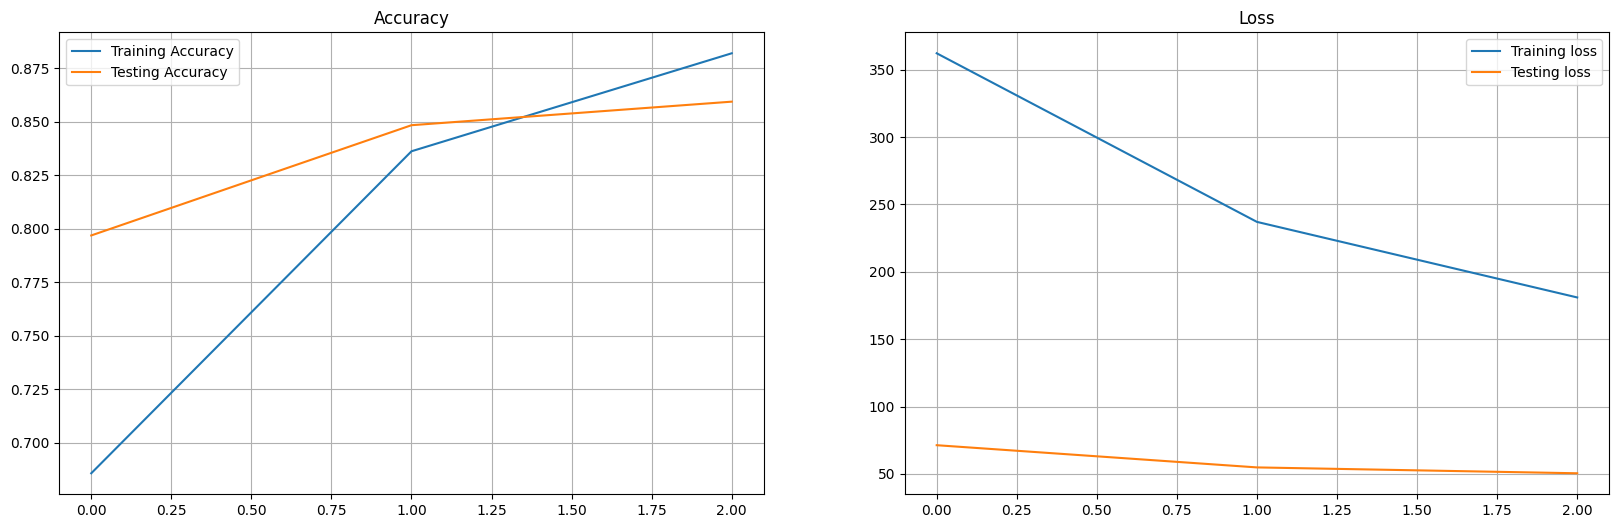

In [43]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_train_acc, label='Training Accuracy')
plt.plot(epoch_test_acc, label='Testing Accuracy')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_loss, label='Training loss')
plt.plot(epoch_test_loss, label='Testing loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()